In [62]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [70]:
df = pd.read_csv('extracted_features/df_features.csv')
print(df.shape)
df.head()

(5125, 98)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_3_std,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std
0,22564_Wedding_music.wav,0.115,0.151,1.317,0.716,0.070,0.052,0.145,0.042,129.199,...,0.246,0.203,0.293,0.194,0.246,0.248,0.276,0.375,0.271,0.350
1,2170_Wedding_music.wav,0.100,0.130,1.386,0.845,0.063,0.013,0.125,0.038,99.384,...,0.283,0.219,0.378,0.177,0.295,0.146,0.229,0.356,0.206,0.285
2,12235_Dance_music.wav,0.377,0.449,0.377,-0.866,0.055,0.039,0.440,0.088,129.199,...,0.226,0.219,0.291,0.283,0.260,0.271,0.307,0.322,0.291,0.294
3,4743_Dance_music.wav,0.092,0.120,1.304,0.651,0.128,0.051,0.115,0.032,151.999,...,0.259,0.361,0.272,0.322,0.197,0.358,0.253,0.236,0.343,0.197
4,17151_Wedding_music.wav,0.192,0.244,1.151,0.294,0.083,0.016,0.236,0.059,92.285,...,0.361,0.192,0.385,0.109,0.133,0.103,0.186,0.233,0.138,0.371


In [71]:
label_dict = {  'Background_music':0,
                'Theme_music':1,
                'Jingle':2,
                'Soundtrack_music':3,
                'Lullaby':4,
                'Video_game_music':5,
                'Christmas_music':6,
                'Dance_music':7,
                'Wedding_music':8}
                # 'Birthday_music':9} 

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_', 1)[1]])
df.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,22564_Wedding_music.wav,0.131944,0.167598,0.220837,0.010117,0.120567,0.197581,0.160894,0.139073,0.493104,...,0.434783,0.613687,0.406852,0.517730,0.509636,0.582766,0.795207,0.550661,0.700000,8
1,2170_Wedding_music.wav,0.114583,0.144134,0.225012,0.010621,0.108156,0.040323,0.138547,0.125828,0.275864,...,0.469565,0.801325,0.370450,0.633570,0.291221,0.476190,0.753813,0.407489,0.564583,8
2,12235_Dance_music.wav,0.435185,0.500559,0.163964,0.003940,0.093972,0.145161,0.490503,0.291391,0.493104,...,0.469565,0.609272,0.597430,0.550827,0.558887,0.653061,0.679739,0.594714,0.583333,7
3,4743_Dance_music.wav,0.105324,0.132961,0.220051,0.009864,0.223404,0.193548,0.127374,0.105960,0.659230,...,0.778261,0.567329,0.680942,0.401891,0.745182,0.530612,0.492375,0.709251,0.381250,7
4,17151_Wedding_music.wav,0.221065,0.271508,0.210794,0.008470,0.143617,0.052419,0.262570,0.195364,0.224139,...,0.410870,0.816777,0.224839,0.250591,0.199143,0.378685,0.485839,0.257709,0.743750,8


In [72]:
# Train-test split of files # Same split as used for VGG model
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:-1]], 
                                                    df['label'],
                                                    random_state = 10, 
                                                    test_size = 0.1
                                                    )




### were is validation set?

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        roles = ['Background', 'Theme', 'Jingle', 'Soundtrack', 'Lullaby', 'Video_game', 'Christmas',
        'Dance', 'Wedding']#, 'Birthday'] # for beatiful plotting
        plot_confusion_matrix(confusion_matrix(y_test[:len(pred)], pred), classes=roles)

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 7 separate classifiers are trained. During test time, the class with the highest prob. from among the 7 classifiers is the predicted class.

Test Set Accuracy =  0.42
Test Set F-score =  0.40
ROC AUC = 0.809
Confusion matrix, without normalization
[[ 8 13  4  4  7  8  1  6 10]
 [ 3 18  7  5  3 11  0  3  9]
 [ 2  4 29  2  2  6  4 12  3]
 [ 3  6  4 12  0 11  2 11  4]
 [ 1  0  1  2 49  0  5  1  4]
 [ 4  8  1  3  1 19  1  3  3]
 [ 6  0 18  3  7  1 18  4  5]
 [ 0  2  1  1  0  2  1 37  3]
 [ 6  6  3  0 12  2  5  1 26]]
CPU times: user 635 ms, sys: 5 µs, total: 635 ms
Wall time: 634 ms


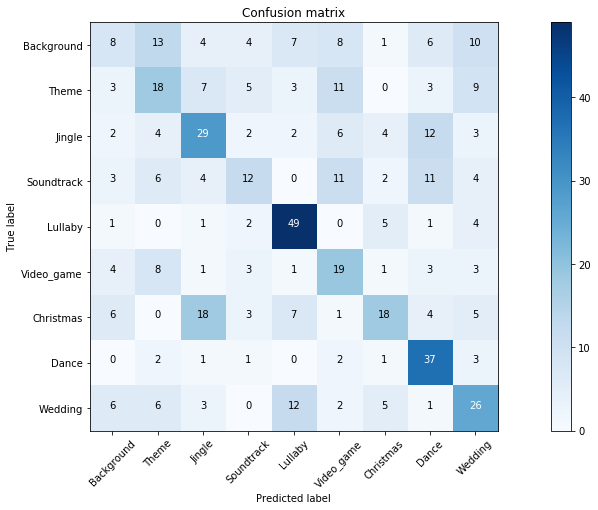

In [74]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Random Forest

Test Set Accuracy =  0.41
Test Set F-score =  0.38
ROC AUC = 0.806
Confusion matrix, without normalization
[[ 9  9  3  3  9  7  6  7  8]
 [ 5 17  6  7  3 11  0  4  6]
 [ 0  1 32  2  3  5  4 14  3]
 [ 4 11  5  7  5  7  1  8  5]
 [ 2  0  2  2 50  0  5  1  1]
 [ 3  6  1  1  3 18  2  4  5]
 [ 4  0 17  2 11  2 17  1  8]
 [ 0  2  3  3  0  3  1 34  1]
 [ 3  2  3  0 16  3  4  3 27]]
CPU times: user 11.3 s, sys: 0 ns, total: 11.3 s
Wall time: 11.3 s


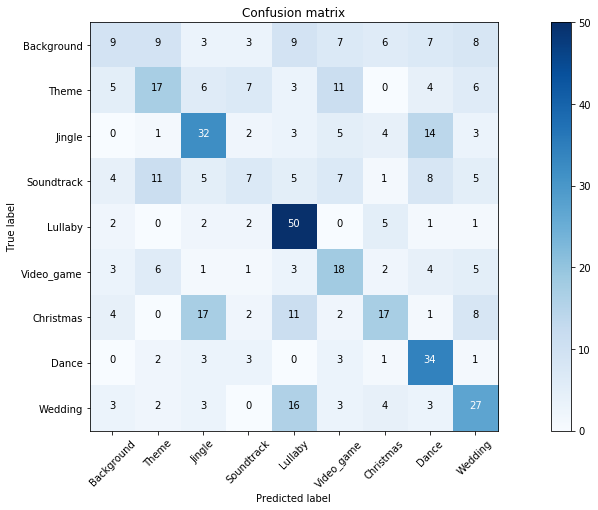

In [81]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Gradient Boosting 

Test Set Accuracy =  0.41
Test Set F-score =  0.40
ROC AUC = 0.809
Confusion matrix, without normalization
[[10 10  4  7  6  9  4  5  6]
 [ 9 27  2  4  3  6  1  4  3]
 [ 3  3 26  3  2  2  5 14  6]
 [ 5  9  5 12  3  8  2  5  4]
 [ 4  0  3  1 42  1  6  1  5]
 [ 3 12  1  6  2 14  1  1  3]
 [ 6  0 22  2  9  0 19  1  3]
 [ 2  3  2  3  0  1  2 33  1]
 [ 4  2  4  0 10  1 10  4 26]]
CPU times: user 1min 54s, sys: 7.13 ms, total: 1min 54s
Wall time: 1min 54s


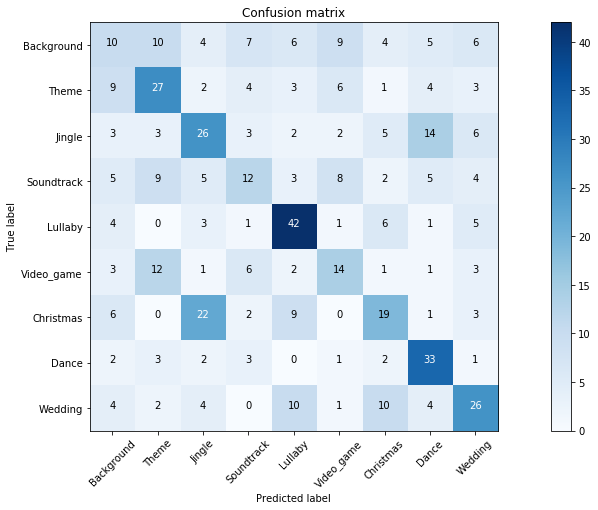

In [77]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Support Vector Machines

Test Set Accuracy =  0.39
Test Set F-score =  0.38
ROC AUC = 0.805
Confusion matrix, without normalization
[[12  9  3  3  7 16  1  7  3]
 [12 16  3  3  0 14  1  5  5]
 [ 1  5 26  3  2  7  8 12  0]
 [ 7  7  6  9  1 11  3  6  3]
 [ 1  0  2  1 46  1  7  1  4]
 [ 5  4  3  4  1 18  1  3  4]
 [ 3  2 15  3  5  3 25  2  4]
 [ 0  4  4  3  0  3  1 29  3]
 [ 5  4  5  1 11  6  7  2 20]]
CPU times: user 59 s, sys: 19.7 ms, total: 59.1 s
Wall time: 59.1 s


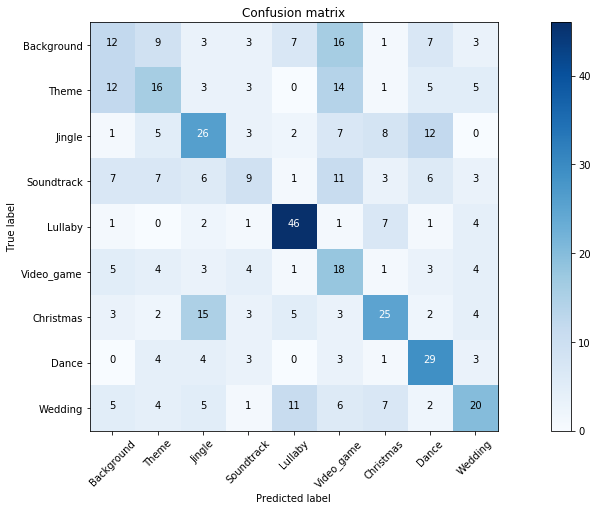

In [78]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, kernel='rbf') # class_weight=cl_weight,
svm_classifier.fit(x_train, y_train)

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/svm_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Most Important Feature
Determine the features that contribute the most towards making the correct classfication

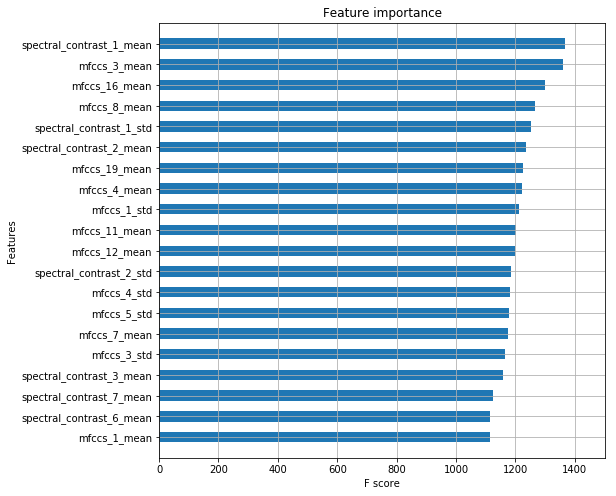

In [58]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
# plt.savefig('plots/feature-imp.png', bbox_inches='tight')

The most important features seem to be MFCCs and spectral contrast (mean and std dev in different frequency bins). Use the top N features, build the model and look at the metrics

In [59]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.00440582, 0.00635904, 0.009078  , 0.00937764, 0.01097572,
       0.01014338, 0.00369557, 0.00972167, 0.00835664, 0.00671417,
       0.00852311, 0.00491632, 0.00684734, 0.00628135, 0.00951081,
       0.        , 0.        , 0.01517068, 0.01371687, 0.01284015,
       0.01138634, 0.01164159, 0.01237404, 0.01248502, 0.01390554,
       0.01317308, 0.01127536, 0.01018777, 0.01016558, 0.01136414,
       0.01129755, 0.00581524, 0.00699161, 0.01237404, 0.00816798,
       0.015093  , 0.0135615 , 0.01218538, 0.01196342, 0.01302881,
       0.01403871, 0.01191903, 0.01137524, 0.01335065, 0.01331735,
       0.01064278, 0.01089803, 0.01217428, 0.01441603, 0.01191903,
       0.01161939, 0.0136059 , 0.01216318, 0.01347272, 0.01220757,
       0.01291783, 0.01310649, 0.0130954 , 0.01173037, 0.01191903,
       0.01115328, 0.00911129, 0.01103121, 0.01085364, 0.00893372,
       0.00993253, 0.00807919, 0.0085564 , 0.00810139, 0.00976606,
       0.01011009, 0.00884494, 0.00928885, 0.01068718, 0.00996

In [60]:
top_n = [10, 20, 30]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                       n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)     
    print()

Stats for top 10 features:
Test Set Accuracy =  0.25
Test Set F-score =  0.24
ROC AUC = 0.675

Stats for top 20 features:
Test Set Accuracy =  0.33
Test Set F-score =  0.32
ROC AUC = 0.747

Stats for top 30 features:
Test Set Accuracy =  0.36
Test Set F-score =  0.35
ROC AUC = 0.762



### Ensemble of XGB and VGG

In [61]:
# Load predicted probabilities
with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/vgg_fine_tuning.pkl', 'rb') as f:
    vgg_pred_probs = pickle.load(f)
    
n_samples = np.min([len(xgb_pred_probs), len(vgg_pred_probs)])

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs[:n_samples] + vgg_pred_probs[:n_samples])/2.0

# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)

ValueError: operands could not be broadcast together with shapes (514,9) (514,7) 

### Plot 3 ROCs the same graph
- VGG
- XGB
- Ensemble

In [8]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class

def plot_roc_curves(y_true, pred_probs, label_dict):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    NUM_CLASSES = len(label_dict)
    one_hot_true = one_hot_encoder(y_true, len(y_true), NUM_CLASSES)
    for i in range(len(label_dict)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

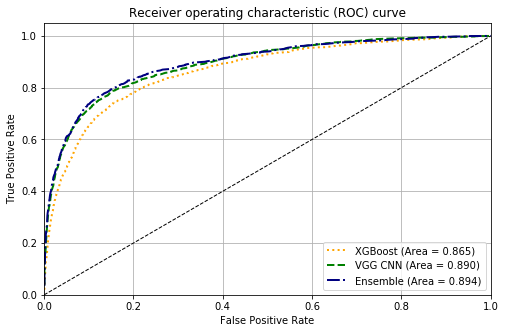

In [9]:
# Plot all ROC curves
plt.figure(figsize=(8,5))

plt.title('Macro-average ROC curves')

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], xgb_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='XGBoost (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='orange', linestyle=':', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], vgg_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='VGG CNN (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='green', linestyle='--', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], ensemble_pred_probs[:n_samples]
                                    , label_dict)
plt.plot(fpr, tpr,
         label='Ensemble (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='navy', linestyle='-.', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
# plt.savefig('plots/roc-curve.png')
plt.show()

#### Time Domain Feature Only

Test Set Accuracy =  0.40
Test Set F-score =  0.34
ROC AUC = 0.731
Confusion matrix, without normalization
[[183  60   8  16  10  34  53]
 [ 59 143  17  12   8 106  38]
 [ 24  32  56   4   2  33  20]
 [ 78  47  12  10  13  41  31]
 [ 40  35   5   5  20  13  14]
 [ 27  70  10   7   7 252  43]
 [ 48  53  12   9   8  62 137]]
CPU times: user 1min 23s, sys: 16.1 ms, total: 1min 23s
Wall time: 1min 23s


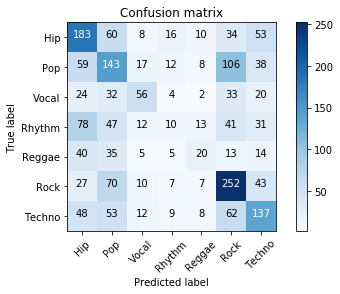

In [14]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,:9], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,:9])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_time_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

#### Frequency Domain Feature Only

Test Set Accuracy =  0.57
Test Set F-score =  0.53
ROC AUC = 0.857
Confusion matrix, without normalization
[[230  55  10  14  16  14  25]
 [ 55 203  18  19   6  52  30]
 [ 12  11 106   6   4  18  14]
 [ 44  62   5  46  19  31  25]
 [ 25  32   5  14  43   8   5]
 [ 13  50   8   5   1 317  22]
 [ 23  31  11   7   3  51 203]]
CPU times: user 17min 8s, sys: 28 ms, total: 17min 8s
Wall time: 17min 8s


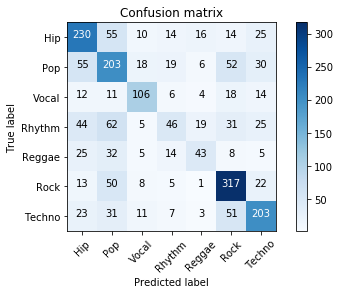

In [15]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,9:], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,9:])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_freq_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)